<a href="https://colab.research.google.com/github/shehabKhamis/skinLesionSegmentation/blob/fcn/lesionSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import pandas as pd
import os
import PIL
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
xTrain=[]
yTrain=[]
Datafr=pd.DataFrame(columns=['feature'])
df=pd.DataFrame(columns=['feature'])
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Data'):
  continue
xTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])


for i in range(100) :
   print(i)
   df.loc[i] = [xTrain[i].flatten()]
#df=pd.DataFrame(data = [[x.flatten()] for x in xTrain])
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/training/ISIC-2017_Training_Part1_GroundTruth'):
  continue
yTrain= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])
               

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [4]:
xValid=[]
yValid=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Data'):
  continue;
xValid= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/validation/ISIC-2017_Validation_Part1_GroundTruth'):
  continue;
yValid= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])
               

In [ ]:

Datafr=pd.DataFrame(df['feature'].values.tolist())
Datafr


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,921560,921561,921562,921563,921564,921565,921566,921567,921568,921569,921570,921571,921572,921573,921574,921575,921576,921577,921578,921579,921580,921581,921582,921583,921584,921585,921586,921587,921588,921589,921590,921591,921592,921593,921594,921595,921596,921597,921598,921599
0,235,244,239,200,220,221,199,231,244,195,233,254,189,225,247,203,232,248,204,226,239,206,228,241,201,228,245,195,230,252,195,231,255,196,233,252,200,233,250,201,...,254.0,231.0,248.0,255.0,228.0,251.0,255.0,227.0,252.0,255.0,227.0,251.0,251.0,231.0,249.0,249.0,236.0,250.0,253.0,236.0,249.0,255.0,227.0,247.0,255.0,223.0,252.0,255.0,221.0,252.0,255.0,228.0,249.0,250.0,232.0,241.0,238.0,255.0,254.0,249.0
1,235,232,239,200,197,204,214,211,218,205,202,209,210,207,216,208,205,214,204,201,210,210,207,216,207,204,213,208,205,214,210,207,216,209,206,215,207,204,211,206,...,242.0,235.0,236.0,240.0,235.0,236.0,240.0,235.0,236.0,240.0,235.0,236.0,241.0,235.0,235.0,243.0,233.0,233.0,243.0,237.0,237.0,247.0,234.0,234.0,244.0,234.0,234.0,244.0,233.0,233.0,241.0,237.0,238.0,243.0,218.0,219.0,223.0,252.0,253.0,255.0
2,223,223,223,154,154,154,166,166,166,154,154,154,154,154,154,167,167,167,160,160,160,157,157,157,161,161,161,160,160,160,160,160,160,161,161,161,160,160,160,158,...,219.0,192.0,209.0,217.0,194.0,209.0,216.0,195.0,208.0,214.0,194.0,207.0,213.0,192.0,205.0,211.0,199.0,212.0,218.0,186.0,197.0,201.0,193.0,204.0,208.0,201.0,209.0,211.0,194.0,200.0,200.0,201.0,203.0,200.0,198.0,199.0,194.0,238.0,237.0,232.0
3,247,246,251,238,237,242,242,241,246,242,241,246,239,238,243,243,242,247,243,242,247,241,240,245,243,243,245,243,243,245,242,242,244,242,242,244,242,242,244,242,...,248.0,245.0,245.0,247.0,245.0,244.0,249.0,245.0,244.0,249.0,246.0,245.0,250.0,247.0,246.0,251.0,244.0,243.0,248.0,246.0,247.0,251.0,245.0,246.0,250.0,246.0,247.0,251.0,242.0,243.0,245.0,243.0,244.0,246.0,240.0,241.0,243.0,254.0,255.0,255.0
4,223,223,223,145,145,145,170,170,170,156,156,156,157,157,157,158,158,158,164,164,164,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,159,...,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,198.0,201.0,201.0,201.0,194.0,194.0,194.0,200.0,200.0,200.0,202.0,202.0,202.0,188.0,188.0,188.0,202.0,202.0,202.0,192.0,192.0,192.0,237.0,237.0,237.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,0,2,...,3.0,11.0,6.0,2.0,10.0,7.0,2.0,9.0,6.0,1.0,9.0,5.0,2.0,9.0,5.0,2.0,6.0,5.0,1.0,6.0,5.0,1.0,6.0,5.0,1.0,5.0,4.0,0.0,4.0,5.0,0.0,3.0,4.0,0.0,3.0,4.0,0.0,3.0,4.0,0.0
96,187,158,140,186,157,139,186,157,139,187,158,140,189,161,140,191,163,142,190,163,142,189,162,141,189,162,141,189,162,143,190,163,144,190,163,146,190,162,148,189,...,131.0,161.0,138.0,130.0,161.0,138.0,130.0,162.0,139.0,131.0,162.0,139.0,133.0,161.0,138.0,132.0,164.0,141.0,135.0,164.0,140.0,136.0,162.0,141.0,136.0,162.0,141.0,136.0,163.0,142.0,137.0,165.0,144.0,139.0,167.0,146.0,141.0,169.0,148.0,145.0
97,183,157,140,184,158,141,185,159,144,184,161,145,184,161,145,184,161,147,182,160,146,181,159,146,183,161,148,183,161,148,182,160,147,182,160,146,183,161,147,185,...,149.0,203.0,168.0,149.0,204.0,169.0,150.0,204.0,169.0,150.0,205.0,169.0,153.0,204.0,171.0,154.0,203.0,170.0,153.0,203.0,172.0,154.0,203.0,172.0,154.0,204.0,173.0,155.0,204.0,173.0,155.0,202.0,173.0,155.0,202.0,173.0,155.0,201.0,172.0,154.0
98,204,166,163,205,167,164,204,169,165,205,170,168,207,172,170,208,172,172,209,173,173,210,174,174,208,174,175,208,174,175,208,174,175,207,173,172,206,172,171,205,...,128.0,182.0,147.0

In [ ]:
Datafr.isnull().values.any()

True

In [12]:
xTest=[]
yTest=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Data'):
  continue;
xTest= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])

for dirname, _, filenames in os.walk('/content/drive/MyDrive/skinLesion/test/ISIC-2017_Test_v2_Part1_GroundTruth'):
  continue;
yTest= np.array([np.array(Image.open(os.path.join(dirname, filename)).resize((640,480)))for filename in sorted(filenames)])
               

In [21]:
xTrain.shape

(2000, 480, 640, 3)

In [6]:
yTrain.shape

(2000, 480, 640)

In [ ]:
xValid.shape

(150,)

In [ ]:
xTest.shape

(600,)

**Data Augmentation**

In [ ]:
def imageHFlip(img):
  img_flip_lr = cv2.flip(img, 1)
  return img_flip_lr


def imageVFlip(img):
  img_flip = cv2.flip(img, 1)
  return img_flip


def rotate(img):
  rot=cv2.rotate(img,cv2.ROTATE_90_CLOCKWISE)
  return rot


def gaussian_blur(image,blur):
    image = cv2.GaussianBlur(image,(5,5),blur)
    return image

def add_light(image, gamma):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    image=cv2.LUT(image, table)
    return image

     


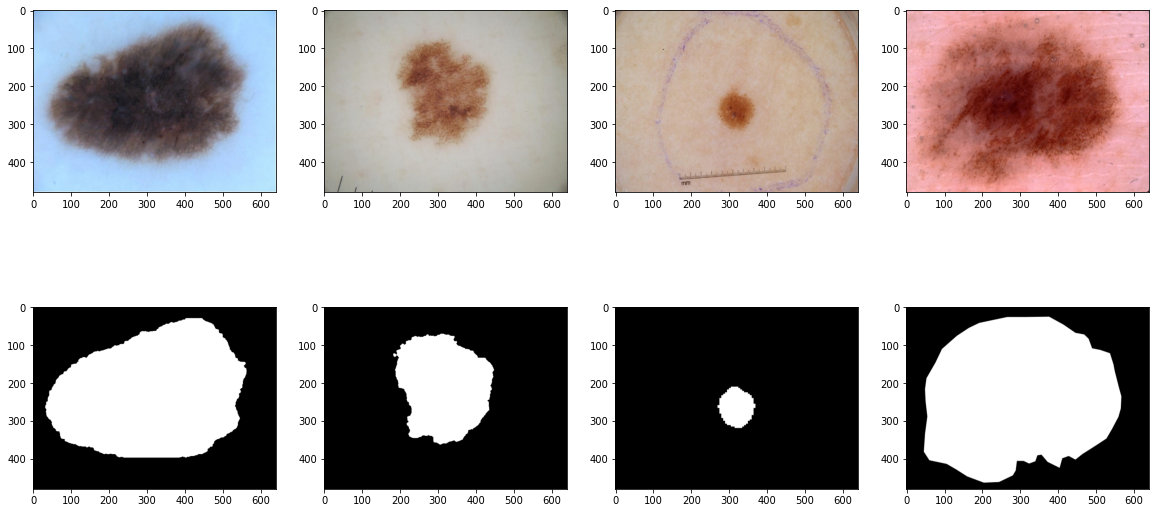

In [5]:
plt.figure(figsize=(20,10))
plt.subplot(2,4,1)
plt.imshow(xTrain[0])
plt.subplot(2,4,2)
plt.imshow(xTrain[600])
plt.subplot(2,4,3)
plt.imshow(xTrain[1200])
plt.subplot(2,4,4)
plt.imshow(xTrain[1900])
plt.subplot(2,4,5)
plt.imshow(yTrain[0],cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(yTrain[600],cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(yTrain[1200],cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(yTrain[1900],cmap = plt.cm.binary_r)

In [6]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))


def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)    
        

In [7]:
def fcn_net(xTrain,epochs_num):

    # Convolution Layers (BatchNorm after non-linear activation)

    img_input = Input(shape= (480, 640, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Dropout(0.5)(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn9')(x)
    
    x = Dropout(0.5)(x)

    x = Activation('sigmoid')(x)
    pred = Reshape((480,640))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou,accuracy])

    hist = model.fit(xTrain, yTrain, epochs= epochs_num, batch_size= 18, validation_data= (xValid, yValid), verbose=1)

    
    return model,hist

In [8]:
model, hist = fcn_net(xTrain,epochs_num= 1 )

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


TypeError: ignored